<a href="https://colab.research.google.com/github/Mollylst/DeepFake-Project/blob/main/DCT_FFHQ_Stylegan2_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/train_fake_stylegan2.zip' -d /content/train
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/train_real.zip' -d /content/train
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/test_fake_stylegan2.zip' -d /content/test
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/test_real.zip' -d /content/test

In [ ]:
!rm -rf my_che test

In [ ]:
import numpy as np
from PIL import Image
from scipy import fftpack

def dct2(array):
    array = fftpack.dct(array, type=2, norm="ortho", axis=0)
    array = fftpack.dct(array, type=2, norm="ortho", axis=1)
    return array

def log_scale(array, epsilon=1e-12):
    """Log scale the input array.
    """
    array = np.abs(array)
    array += epsilon  # no zero in log
    array = np.log(array)
    return array

In [ ]:
import cv2
import os
import numpy as np
import random
import torch
import torchvision
import os
from torchvision import datasets 
from torch.utils.data import random_split
import torchvision.transforms as transforms

def image2npy(label2idx, dir_path='/content/train'):
    i = 0
    data = []
    for (root, dirs, files) in os.walk(dir_path):
        for file in files: 
            img_path = os.path.join(root, file) 
            File = root.split('/')[-1] #name of the file which is label
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = np.asarray(image)
            image = dct2(image)
            image = log_scale(image)

            label = label2idx[File]
            data.append([np.asarray(image), label])
    return data

In [ ]:
label2idx = {'fake':1, 'real': 0}
data = image2npy(label2idx, dir_path='/content/train')

train_data,valid_data = random_split(data,[16000,2000])

X_train = np.array([i[0] for i in train_data]) # train feature
X_train_max = X_train.max(0)
X_train = X_train/X_train_max
y_train = np.array([i[1] for i in train_data]) # train label

X_valid = np.array([i[0] for i in valid_data]) 
X_valid_max = X_valid.max(0)
X_valid = X_valid/X_valid_max
y_valid = np.array([i[1] for i in valid_data]) 
print(len(X_train), len(y_train), len(X_valid), len(y_valid))

np.save('drive/MyDrive/train-images-ffhq-stylegan2.npy', X_train)
np.save('drive/MyDrive/train-labels-ffhq-stylegan2.npy', y_train)
np.save('drive/MyDrive/valid-images-ffhq-stylegan2.npy', X_valid)
np.save('drive/MyDrive/valid-labels-ffhq-stylegan2.npy', y_valid)

data = image2npy(label2idx, dir_path='/content/test')

X_test = np.array([i[0] for i in data]) # test feature
X_test_max = X_test.max(0)
X_test = X_test/X_test_max
y_test = np.array([i[1] for i in data]) # test label 
print(len(X_test), len(y_test))

np.save('drive/MyDrive/test-images-ffhq-stylegan2.npy', X_test)
np.save('drive/MyDrive/test-labels-ffhq-stylegan2.npy', y_test)

16000 16000 2000 2000
2000 2000


Text(0.5, 1.0, 'difference')

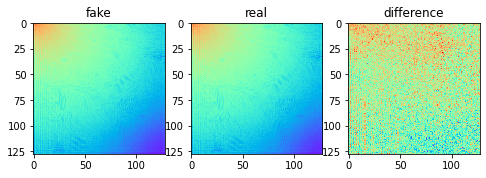

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(8,8))
axes[0].imshow(X_train[y_train==label2idx['fake']].mean(0),cmap='rainbow',interpolation='none')
axes[0].set_title('fake')
axes[1].imshow(X_train[y_train==label2idx['real']].mean(0),cmap='rainbow',interpolation='none')
axes[1].set_title('real')
axes[2].imshow(X_train[y_train==label2idx['fake']].mean(0)-X_train[y_train==label2idx['real']].mean(0),cmap='rainbow',interpolation='none')
axes[2].set_title('difference')

In [ ]:
import torch
import torchvision
import numpy as np
from torchvision import datasets 

train_images = np.load('./drive/MyDrive/train-images-ffhq-stylegan2.npy')
train_labels = np.load('./drive/MyDrive/train-labels-ffhq-stylegan2.npy')
valid_images = np.load('./drive/MyDrive/valid-images-ffhq-stylegan2.npy')
valid_labels = np.load('./drive/MyDrive/valid-labels-ffhq-stylegan2.npy')
test_images = np.load('./drive/MyDrive/test-images-ffhq-stylegan2.npy')
test_labels = np.load('./drive/MyDrive/test-labels-ffhq-stylegan2.npy')

X_train = torch.from_numpy(train_images).float() 
X_valid = torch.from_numpy(valid_images).float()
X_test = torch.from_numpy(test_images).float()
Y_train = torch.from_numpy(train_labels).long() 
Y_valid = torch.from_numpy(valid_labels).long()
Y_test = torch.from_numpy(test_labels).long()

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

MINIBATCH_SIZE = 128

trainDataset = torch.utils.data.TensorDataset(X_train, Y_train) 
trainloader = torch.utils.data.DataLoader(
    dataset=trainDataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2          # set multi-work num read data
)

image, label = iter(trainloader).next()
print(type(image), type(label))
print(image.size(), label.size())

validDataset = torch.utils.data.TensorDataset(X_valid, Y_valid) 
validloader = torch.utils.data.DataLoader(
    dataset=validDataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=False,
    num_workers=2          # set multi-work num read data
)

testDataset = torch.utils.data.TensorDataset(X_test, Y_test) 
testloader = torch.utils.data.DataLoader(
    dataset=testDataset,
    batch_size=MINIBATCH_SIZE, 
    shuffle=False, 
    num_workers=2 
)

torch.Size([16000, 128, 128]) torch.Size([16000])
torch.Size([2000, 128, 128]) torch.Size([2000])
torch.Size([2000, 128, 128]) torch.Size([2000])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([128, 128, 128]) torch.Size([128])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [ ]:
import torch.nn as nn
input_size=16384
num_classes=2

class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return torch.sigmoid(out)
        #return out
 
net = LogisticRegression(input_size, num_classes).to(device)

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0, last_epoch=-1, verbose=False)

Epoch: 1/50
Epoch: 001, Training: Loss: 0.6930, Accuracy: 51.3938%, 
		Validation: Loss: 0.6909, Accuracy: 52.6000%, Time: 2.7116s
Best Accuracy for validation : 0.5260 at epoch 001
Epoch: 2/50
Epoch: 002, Training: Loss: 0.6890, Accuracy: 53.9438%, 
		Validation: Loss: 0.6907, Accuracy: 52.9000%, Time: 2.4999s
Best Accuracy for validation : 0.5290 at epoch 002
Epoch: 3/50
Epoch: 003, Training: Loss: 0.6861, Accuracy: 55.0750%, 
		Validation: Loss: 0.6896, Accuracy: 53.5000%, Time: 2.4764s
Best Accuracy for validation : 0.5350 at epoch 003
Epoch: 4/50
Epoch: 004, Training: Loss: 0.6819, Accuracy: 57.4875%, 
		Validation: Loss: 0.6918, Accuracy: 52.4500%, Time: 2.4501s
Best Accuracy for validation : 0.5350 at epoch 003
Epoch: 5/50
Epoch: 005, Training: Loss: 0.6792, Accuracy: 58.2938%, 
		Validation: Loss: 0.6896, Accuracy: 53.2500%, Time: 2.4654s
Best Accuracy for validation : 0.5350 at epoch 003
Epoch: 6/50
Epoch: 006, Training: Loss: 0.6764, Accuracy: 59.8875%, 
		Validation: Loss: 0

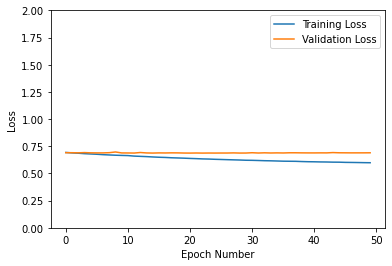

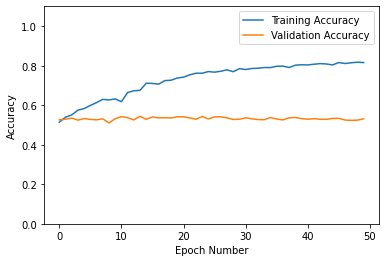

In [ ]:
import time
import matplotlib.pyplot as plt

num_epoch=50
path='./deepfake-LR.pth'

def train_and_valid():
    history = []
    best_acc = 0.0
    best_epoch = 0
    
    for epoch in range(0,num_epoch):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epoch))

        net.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        #train
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.reshape(-1, 128*128).to(device)
            labels = labels.to(device)  # Labels
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs,labels)

            #L1_reg = 0
            #for param in model.parameters():
              #L1_reg += torch.sum(torch.abs(param))
            #loss += 0.001 * L1_reg  # lambda=0.001
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _,predictions = torch.max(outputs.data, 1)
            train_acc += (predictions == labels).sum().item()

        #valid
        net.eval()
        with torch.no_grad():

            for j, (inputs, labels) in enumerate(validloader):

                inputs = inputs.reshape(-1, 128*128).to(device)
                labels = labels.to(device)  # Labels
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                _,predictions = torch.max(outputs.data, 1)
                valid_acc += (predictions == labels).sum().item()
 
        avg_train_loss = train_loss/ len(trainDataset)
        avg_train_acc = train_acc/ len(trainDataset)
 
        avg_valid_loss = valid_loss/ len(validDataset)
        avg_valid_acc = valid_acc/ len(validDataset)

        #record the accuracy and loss in each epoch
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(net.state_dict(),path)
        scheduler.step()  

        epoch_end = time.time()
        
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))

    return history
    
#start training and testing
history = train_and_valid()

#make the plots
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 2)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(out.shape[0],-1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

#define ResNet18
net = ResNet18().to(device)

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0, last_epoch=-1, verbose=False)

Epoch: 1/50
Epoch: 001, Training: Loss: 0.6958, Accuracy: 51.4563%, 
		Validation: Loss: 0.7219, Accuracy: 50.6000%, Time: 110.0594s
Best Accuracy for validation : 0.5060 at epoch 001
Epoch: 2/50
Epoch: 002, Training: Loss: 0.6840, Accuracy: 55.1875%, 
		Validation: Loss: 0.7049, Accuracy: 52.6500%, Time: 109.9186s
Best Accuracy for validation : 0.5265 at epoch 002
Epoch: 3/50
Epoch: 003, Training: Loss: 0.6669, Accuracy: 61.5875%, 
		Validation: Loss: 0.7426, Accuracy: 51.6000%, Time: 109.8096s
Best Accuracy for validation : 0.5265 at epoch 002
Epoch: 4/50
Epoch: 004, Training: Loss: 0.6286, Accuracy: 68.3312%, 
		Validation: Loss: 0.7293, Accuracy: 51.8500%, Time: 109.8181s
Best Accuracy for validation : 0.5265 at epoch 002
Epoch: 5/50
Epoch: 005, Training: Loss: 0.5680, Accuracy: 72.6750%, 
		Validation: Loss: 1.2067, Accuracy: 50.7500%, Time: 109.8070s
Best Accuracy for validation : 0.5265 at epoch 002
Epoch: 6/50
Epoch: 006, Training: Loss: 0.4966, Accuracy: 76.6625%, 
		Validatio

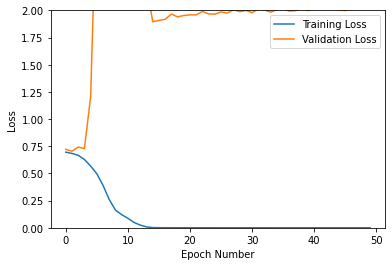

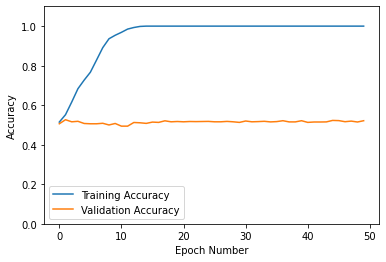

In [ ]:
import time
import matplotlib.pyplot as plt

num_epoch=50
path='./deepfake-LR.pth'

def train_and_valid():
    history = []
    best_acc = 0.0
    best_epoch = 0
    
    for epoch in range(0,num_epoch):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epoch))

        net.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        #train
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.reshape(-1, 1, 128, 128).to(device)
            labels = labels.to(device)  # Labels
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs,labels)

            #L1_reg = 0
            #for param in model.parameters():
              #L1_reg += torch.sum(torch.abs(param))
            #loss += 0.001 * L1_reg  # lambda=0.001
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _,predictions = torch.max(outputs.data, 1)
            train_acc += (predictions == labels).sum().item()

        #valid
        net.eval()
        with torch.no_grad():

            for j, (inputs, labels) in enumerate(validloader):

                inputs = inputs.reshape(-1, 1, 128, 128).to(device)
                labels = labels.to(device)  # Labels
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                _,predictions = torch.max(outputs.data, 1)
                valid_acc += (predictions == labels).sum().item()
 
        avg_train_loss = train_loss/ len(trainDataset)
        avg_train_acc = train_acc/ len(trainDataset)
 
        avg_valid_loss = valid_loss/ len(validDataset)
        avg_valid_acc = valid_acc/ len(validDataset)

        #record the accuracy and loss in each epoch
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(net.state_dict(),path)
        scheduler.step()  

        epoch_end = time.time()
        
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))

    return history
    
#start training and testing
history = train_and_valid()

#make the plots
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 2)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()